<img src = 'image/k-water_logo.png' alt = 'Drawing' style = 'width: 200px;'/>

<p style='font-size:30px; line-height:1em'>[Notebook] RO(역삼투) 막 공정 연속운전시간 예측 </p>

# 분석개요

## 분석주제 및 목표

* RO막 상태 운영예측 모델 개발
  - Neural Network 모델을 활용하여 RO막 상태를 대표하는 연속운전시간 예측

## 분석과정
분석환경 설정 > 데이터 가져오기> 데이터 전처리> 데이터 탐색 > 모델링

* 데이터 전처리: 데이터형 변환, 요약변수 생성, 변수선택, 스케일링
* 데이터 탐색: 히스토그램, 산점도를 통한 종속변수 및 독립변수 탐색
* 모델링: Neural Network

## 데이터 설명
* 데이터 유형: xlsx 파일
* 파일 크기: 16개 시트(sheet), 관측치 총 185,071개(행), 변수 19개(열), 21MB
* 데이터 수집: 당진 산업용수 생산시설에서 2019년 4월부터 2021년 7월까지 수집
* 데이터 내용: 수처리 공정 및 RO막 공정 모니터링 데이터
* 비고: 운영 상의 이유로 가동을 일시 정지한 경우가 있음. 이러한 경우는 모니터링 장치에서 연속 운전시간 또한 잠시 정지하여 기록함.

## 변수 설명
총 변수 수: 19개  

* 시간 변수: DATE
* 측정 변수  
  + RUNNINGTIME(누적 RO막 공정 운전시간)
  + INP(유입압), DP(차압)
  + STOP_REASON(세정사유)
  + RAW_CON(원수 전기전도도), RAW_TUR(원수 탁도), RAW_HARD(원수 경도), RAW_CL(원수 염소이온)
  + DF_TUR(DF 유출탁도), AMF1_TUR(AMF1기 유출탁도), AMF2_TUR(AMF2기 유출탁도), AMF3_TUR(AMF3기 유출탁도), UF_TUR(UF 유출탁도) 
  + FIRST_CON(1차 농축수 전기전도도)
  + AMF1_SDI(AMF1기 SDI), AMF2_SDI(AMF2기 SDI), AMF3_SDI(AMF3기 SDI), UF_SDI(UF SDI), 
* (참고) '3. 데이터 가져오기'에서 raw data를 가공하여 분석용 데이터셋을 생성하고, 생성한 데이터셋으로 모델 학습 및 평가 진행

# 분석환경 설정

In [1]:
# 작업 디렉토리 설정
setwd(paste0('/home/', Sys.getenv('USER') ,'/recipe03'))

## 패키지 불러오기

* readxl : read_xls(), excel_sheets()
* lubridate : ymd_hm()
* dplyr : mutate(), select(), bind_rows(), arrange()
* ggplot2 : ggplot()
* gridExtra : grid.arrange()
* xgboost : xgboost(), xgb.importance()
* neuralnet : neuralnet()
* reshape : plot.nnet_fn()
* ModelMetrics : rmse()

In [2]:
# 패키지 불러오기
suppressPackageStartupMessages({
    library(readxl)
    library(lubridate)
    library(dplyr)
    library(ggplot2)
    library(gridExtra)
    library(xgboost)
    library(neuralnet)
    library(reshape)
    library(ModelMetrics)
})

## 사용자 함수 불러오기

* plot_nnet_fn: neuralnet()함수에 의해 생성되는 class 'nn' 객체를 위한 시각화

In [3]:
# 사용자 함수 불러오기

# plot_nnet_fn: neuralnet()함수에 의해 생성되는 class 'nn' 객체를 위한 시각화
source('src/R_function.r')

# 데이터 가져오기

In [4]:
# 파일 경로
filepath <- 'input/kwater_recipe03_dataset.xlsx'

# xls 파일 시트 목록
sheet_list <- excel_sheets(path = filepath)
sheet_list

[1] "101" "102" "103" "104" "105" "106" "107" "108" "201" "202" "203" "204"
[13] "205" "206" "207" "208"

본 과제에서 사용하는 xlsx 파일은 시트(sheet)를 여러 개 가지고 있습니다. 각 시트에는 시트명에 해당하는 RO(Reverse Osmosis, 역삼투) 블록에서 수집한 데이터가 저장되어 있습니다.  
시트별로 데이터를 불러오기 위해 excel_sheets() 함수를 사용하여 xls 파일이 가지고 있는 시트명을 sheet_list에 저장합니다.  
sheet_list를 보면 101부터 108, 201부터 208까지 총 16개의 시트가 있음을 알 수 있습니다.  

In [5]:
# 변수 생성
data_list <- vector(mode = 'list', length = length(sheet_list))  # 시트별 데이터를 저장할 빈 리스트(empty list) 생성

for(k in 1:length(sheet_list)){
    # -------------------------------------------------------------------
    # (1) 데이터 불러오기
    # -------------------------------------------------------------------    
    operation_df <- read_excel(filepath, sheet = sheet_list[k])
    # -------------------------------------------------------------------
    # (2) 데이터형 변환 및 정렬
    # -------------------------------------------------------------------     
    operation_df$DATE <- ymd_hm(operation_df$DATE)  # 데이터형 변환
    operation_df <- arrange(operation_df, DATE)  # DATE 기준 오름차순 정렬
    # -------------------------------------------------------------------
    # (3) 공정 가동 시작/종료 시간 추출
    # -------------------------------------------------------------------
    # 공정 가동 시작 >> RUNNINGTIME == 0
    start_time <- subset(operation_df, RUNNINGTIME == 0)$DATE
    start_index <- which(operation_df$DATE %in% start_time)
    # 공정 가동 종료 >> 세정사유 != NA
    end_time <- subset(operation_df, is.na(STOP_REASON) != TRUE)$DATE
    end_index <- which(operation_df$DATE %in% end_time)
    # -------------------------------------------------------------------
    # (4) 1회 연속운전시간
    # -------------------------------------------------------------------
    # 누적 운영시간
    CUM_RUNNINGTIME <- operation_df[end_index, ]$RUNNINGTIME
    # -------------------------------------------------------------------
    # (5) 24시간 기준 변화량 계산(유입압)
    # -------------------------------------------------------------------
    # 초기 유입압. 안정화를 위해 가동 시작 1시간 후 데이터 사용
    start_inp <- operation_df[start_index + 1, ]$INP
    # 중지 유입압. 안정화를 위해 가동 종료 1시간 전 데이터 사용
    end_inp <- operation_df[end_index - 1, ]$INP
    # 24시간 기준 변화량
    inp = ((end_inp - start_inp) / CUM_RUNNINGTIME) * 24
    # -------------------------------------------------------------------
    # (6) 24시간 기준 변화량 계산(차압)
    # -------------------------------------------------------------------
    # 초기 차압. 안정화를 위해 가동 시작 1시간 후 데이터 사용
    start_dp <- operation_df[start_index + 1, ]$DP
    # 중지 차압. 안정화를 위해 가동 종료 1시간 전 데이터 사용
    end_dp <- operation_df[end_index - 1, ]$DP
    # 24시간 기준 변화량 변화값
    dp <- ((end_dp - start_dp) / CUM_RUNNINGTIME) * 24
    # -------------------------------------------------------------------
    # (7) 24시간 기준 누적값 계산(수질 변수)
    # -------------------------------------------------------------------
    # 수질값 계산   
    cum_waterquality_list <- vector(mode = 'list', length = length(CUM_RUNNINGTIME))
    for(i in 1:length(CUM_RUNNINGTIME)){
        # 가동 시간동안의 수질 데이터 추출
        subset_df <- subset(operation_df, DATE >= start_time[i] & DATE <= end_time[i], select = -c(DATE, RUNNINGTIME, INP, DP, STOP_REASON))
        # 변수별 합계
        sum_waterquality <- apply(subset_df, 2, sum)
        # 변수별 24시간 기준 누적값
        cum_waterquality <- (sum_waterquality/CUM_RUNNINGTIME[i]) * 24
        cum_waterquality_list[[i]] <- cum_waterquality
    }
    # 데이터 병합(행 결합)
    cum_waterquality_df <- do.call('rbind', cum_waterquality_list)
    # -------------------------------------------------------------------
    # (8) 분석용 데이터셋
    # -------------------------------------------------------------------
    # runningtime, inp, dp, 수질변수 병합(열 결합)
    merged_df <- data.frame(CUM_RUNNINGTIME = CUM_RUNNINGTIME, INP = inp, DP = dp, cum_waterquality_df)
    # list에 데이터 저장
    data_list[[k]] <- merged_df
}
# do.call(): list에 저장되어 있는 각 데이터들에 대해 rbind() 적용
data_df <- do.call('rbind', data_list)

**(1) 첫번째 시트의 데이터를 불러옵니다.**  
read_excel() 함수는 데이터를 tibble class로 저장합니다. tibble class는 data.frame과 유사한 class입니다. 시간이 흐르며 R에서 예전에는 유용했던 동작들이 이제는 그렇지 않은 경우가 있는데, 이를 보완하여 tibble class가 만들어졌습니다. tibble class에서 변수를 벡터로 추출하려면 '$'와 '[[' 를 사용해야합니다. data.frame class와 달리 '['를 사용하면 추출한 데이터는 tibble class로 생성됩니다.

**(2) lubradate 패키지의 ymd_hm()함수를 사용하여 DATE를 날짜·시간형으로 변환합니다.**  
변수형을 변환한 후에는 오름차순으로 정렬합니다.

**(3) 종속변수로 사용할 1회 연속운전시간을 추출하기 위해 조건을 설정합니다.**  
공정이 시작되면 모니터링 장치는 운전시간(RUNNINGTIME)을 0부터 순서대로 저장하며 데이터를 수집합니다. 최대 운전시간(800시간)을 초과하거나, 막이 오염되어 세척을 위해 가동을 중단하면 데이터 수집도 중단됩니다. 이 후 공정을 다시 가동하면 운전시간은 0부터 기록됩니다.
아래와 같은 조건을 만족하는 행의 번호와 DATE를 저장합니다. 저장한 가동 시작/종료 시간과 행 번호는 데이터 추출을 할 때 조건으로 활용합니다.  
  - 가동 시작: RUNNINGTIME == 0
  - 가동 종료: 세정사유 != NA

**(4) 종속변수로 사용할 1회 연속운전시간을 추출합니다.**  
1회 연속운전시간은 공정이 시작되어 RO막 오염 등으로 공정이 중단될 때까지의 시간을 의미합니다. 1회 연속운전시간은 가동이 종료되는 시점의 RUNNINGTIME 값이므로 앞서 저장했던 end_index를 활용합니다.

**(5) 24시간 기준 유입압 변화량을 계산합니다.**  
RO막 공정은 역삼투막에 물을 통과시켜 정수합니다. 물을 막에 통과시키기 위해 삼투압 이상의 압력을 가해야하는데, 이때 가해지는 압력을 유입압이라고 합니다.  
공정이 시작될 때의 유입압이 초기 유입압, 종료될 때의 유입압이 중지 유입압입니다. 막이 오염될수록 막을 통과하기 위해 가해야하는 압력이 커집니다.  
공정이 처음 시작되는 순간과 종료되는 순간에 수집된 데이터는 다소 불안정한 경향이 있습니다. 따라서 분석에서는 공정이 시작되고 1시간 후의 초기 유입압과 공정이 종료되기 1시간 전의 중지 유입압을 사용합니다.  
중지 유입압에서 초기 유입압을 빼서 유입압 변화량을 계산합니다. 그리고 유입압 변화량을 누적 운영시간으로 나눈 뒤 24(시간)를 곱하여 24시간 기준 변화량을 산출합니다.  

**(6) 24시간 기준 차압 변화량을 계산합니다.**  
RO막 공정 설비에서 RO막은 여러 개로 구성되어 하나의 블록(유닛)을 이룹니다. 물이 블록으로 처음 들어갈 때(유입)의 압력과 여러 개의 막을 거쳐 유닛을 나올 때(유출)의 압력에는 차이가 있습니다.  
이 압력의 차이를 차압이라고 합니다. 공정이 운영되며 막에 오염물질이 쌓이면 압력 차이가 더 크게 벌어져 차압이 증가합니다. 앞선 유입압과 동일하게 공정이 시작되고 1시간 후의 초기 차압과 공정이 종료되기 1시간 전의 중지 차압으로 차압 변화량을 계산합니다. 그리고 차압 변화량을 누적 운영시간으로 나눈 뒤 24(시간)를 곱하여 24시간 기준 변화량을 산출합니다.

**(7) 수질 변수들의 24시간 기준 누적값을 계산합니다.**  
수질 관련 변수(원수 전기전도도(RAW_CON), 원수 탁도(RAW_TUR), DF 공정 탁도(DF_TUR), AMF 1기/2기/3기 탁도(AMF1_TUR/AMF2_TUR/AMF3_TUR), UF 공정 탁도(UF_TUR) 등)들에 대해 가동 시간동안의 누적합을 계산한 후, 누적 운영시간으로 나눈 뒤 24(시간)을 곱하여 계산합니다.

**(8) 1회 연속운전시간, 유입압·차압의 일평균 변화량, 수질 변수의 일평균값을 합쳐 하나의 데이터셋을 구성합니다.**  
이렇게 '101' 공정의 운전 데이터를 정리하였습니다. 16개의 RO블록 공정 운전데이터를 1회 가동 기준으로 정리한 데이터셋은 총 459개 행, 17개 열을 가지고 있습니다.  

In [6]:
# 데이터 살펴보기
head(data_df, n = 10)

,CUM_RUNNINGTIME,INP,DP,RAW_CON,RAW_TUR,DF_TUR,AMF1_TUR,AMF2_TUR,AMF3_TUR,UF_TUR,FIRST_CON,AMF1_SDI,AMF2_SDI,AMF3_SDI,UF_SDI,RAW_HARD,RAW_CL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,694,0.07469741,0.03648415,27753.75,25.51686,6.775850,3.018847,2.231066,2.222205,0.5526225,149509.69,125.98996,119.56924,102.21578,50.64579,6162.149,4007.355
2,724,0.08038674,0.03596685,11938.74,17.21296,8.481754,2.697812,2.684818,1.810069,0.5096132,79216.04,80.80067,82.98213,61.56318,32.07671,3129.514,2512.249
3,622,0.13254019,0.09067524,18963.40,15.75333,7.290386,1.681640,1.864688,1.609727,0.5585852,108442.80,100.40939,96.93782,71.62502,58.03854,4318.898,2166.858
4,294,0.17551020,0.09918367,20612.90,20.22602,5.987041,2.546694,1.672531,1.642653,0.5057142,116935.18,77.14319,83.69038,61.28206,52.87084,4425.714,2546.459
5,390,0.10892308,0.05907692,21689.42,16.78277,6.033231,2.750031,2.953015,1.858462,0.5038461,123059.45,95.63688,94.55909,78.01565,54.86952,4521.231,2859.199
6,167,0.23928144,0.15377246,22095.81,24.94078,4.992754,2.674778,3.458156,2.275150,0.4954491,124351.90,85.38638,88.09696,92.95845,58.43636,4571.554,3575.888
7,474,0.08303797,0.07367089,24060.15,33.86671,3.926456,1.898785,2.915848,1.238038,0.4935021,137498.73,90.24022,93.27372,67.84761,55.20291,4626.187,4324.450
8,239,0.14912134,0.11799163,24606.18,26.79992,4.182929,1.442008,1.962226,1.531883,0.4835983,139933.26,86.55186,89.17918,69.10890,52.26723,4932.281,4392.152
9,167,0.15017964,0.16670659,22910.23,21.22329,5.703593,2.107545,2.325413,1.796407,0.5396407,129459.16,100.95403,102.42322,74.61298,55.03601,4626.855,3802.296


분석용 데이터셋은 총 17개의 변수로 이루어져있습니다.

* 종속 변수: CUM_RUNNINGTIME(1회 연속운전시간)
* 독립 변수
  * INP(24시간 기준 유입압 변화량), DP(24시간 기준 차압 변화량)
  * RAW_CON(24시간 기준 누적 원수 전기전도도), RAW_TUR(24시간 기준 누적 원수 탁도), RAW_HARD(24시간 기준 누적 원수 경도), RAW_CL(24시간 기준 누적 원수 염소이온)
  * DF_TUR(24시간 기준 누적 DF 유출탁도), AMF1_TUR(24시간 기준 누적 AMF1기 유출탁도), AMF2_TUR(24시간 기준 누적 AMF2기 유출탁도), AMF3_TUR(24시간 기준 누적 AMF3기 유출탁도), UF_TUR(24시간 기준 누적 UF 유출탁도)
  * FIRST_CON(24시간 기준 누적 1차 농축수 전기전도도)
  * AMF1_SDI(24시간 기준 누적 AMF1기 SDI), AMF2_SDI(24시간 기준 누적 AMF2기 SDI), AMF3_SDI(24시간 기준 누적 AMF3기 SDI), UF_SDI(24시간 기준 누적 UF SDI)

In [7]:
# 데이터 요약하기
summary(data_df)

 CUM_RUNNINGTIME      INP                 DP              RAW_CON     
 Min.   : 20.0   Min.   :0.007644   Min.   :0.004642   Min.   : 6423  
 1st Qu.:226.5   1st Qu.:0.098362   1st Qu.:0.069531   1st Qu.:17838  
 Median :383.0   Median :0.146337   Median :0.101579   Median :21486  
 Mean   :402.2   Mean   :0.199997   Mean   :0.154051   Mean   :20281  
 3rd Qu.:612.5   3rd Qu.:0.218912   3rd Qu.:0.161286   3rd Qu.:24248  
 Max.   :781.0   Max.   :1.086923   Max.   :1.056923   Max.   :28427  
    RAW_TUR          DF_TUR          AMF1_TUR         AMF2_TUR     
 Min.   :11.28   Min.   : 1.525   Min.   :0.8938   Min.   :0.7794  
 1st Qu.:15.63   1st Qu.: 3.882   1st Qu.:1.6515   1st Qu.:1.8055  
 Median :17.84   Median : 5.650   Median :2.0746   Median :2.1437  
 Mean   :18.75   Mean   : 5.705   Mean   :2.1347   Mean   :2.1898  
 3rd Qu.:20.56   3rd Qu.: 7.382   3rd Qu.:2.6635   3rd Qu.:2.6462  
 Max.   :36.39   Max.   :13.037   Max.   :3.9437   Max.   :4.1987  
    AMF3_TUR           UF_T

# 데이터 탐색

## 종속변수에 대한 탐색적 분석

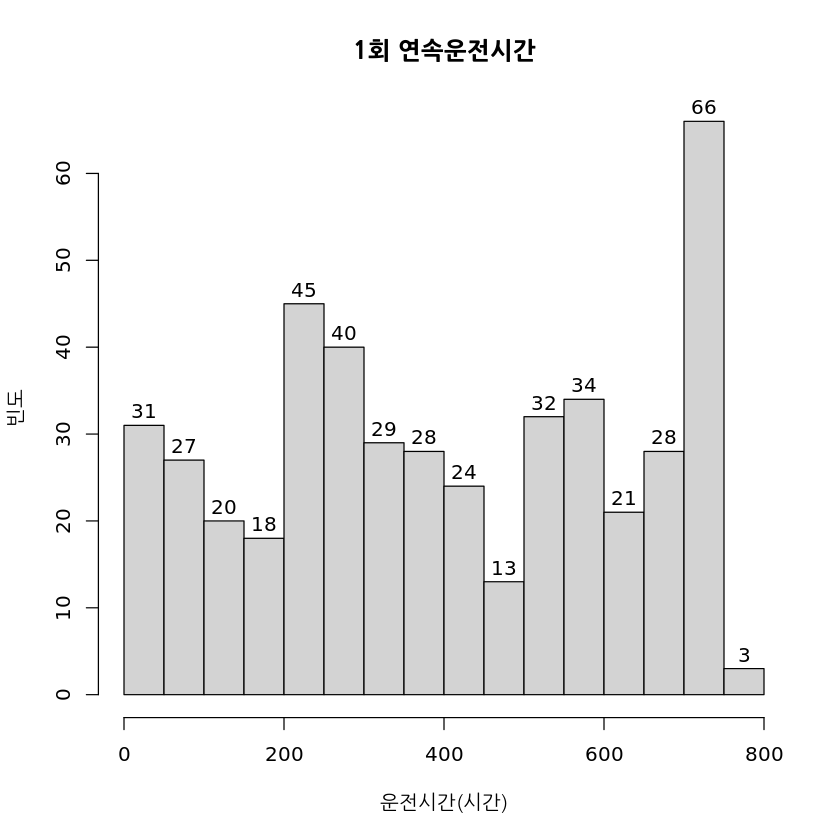

In [8]:
# 히스토그램(종속변수)
hist(data_df$CUM_RUNNINGTIME, breaks = 20, labels = TRUE,
    xlab = '운전시간(시간)', ylab = '빈도', main = '1회 연속운전시간')

종속변수인 1회 연속운전시간을 히스토그램으로 나타낸 결과입니다.

## 독립변수에 대한 탐색적 분석

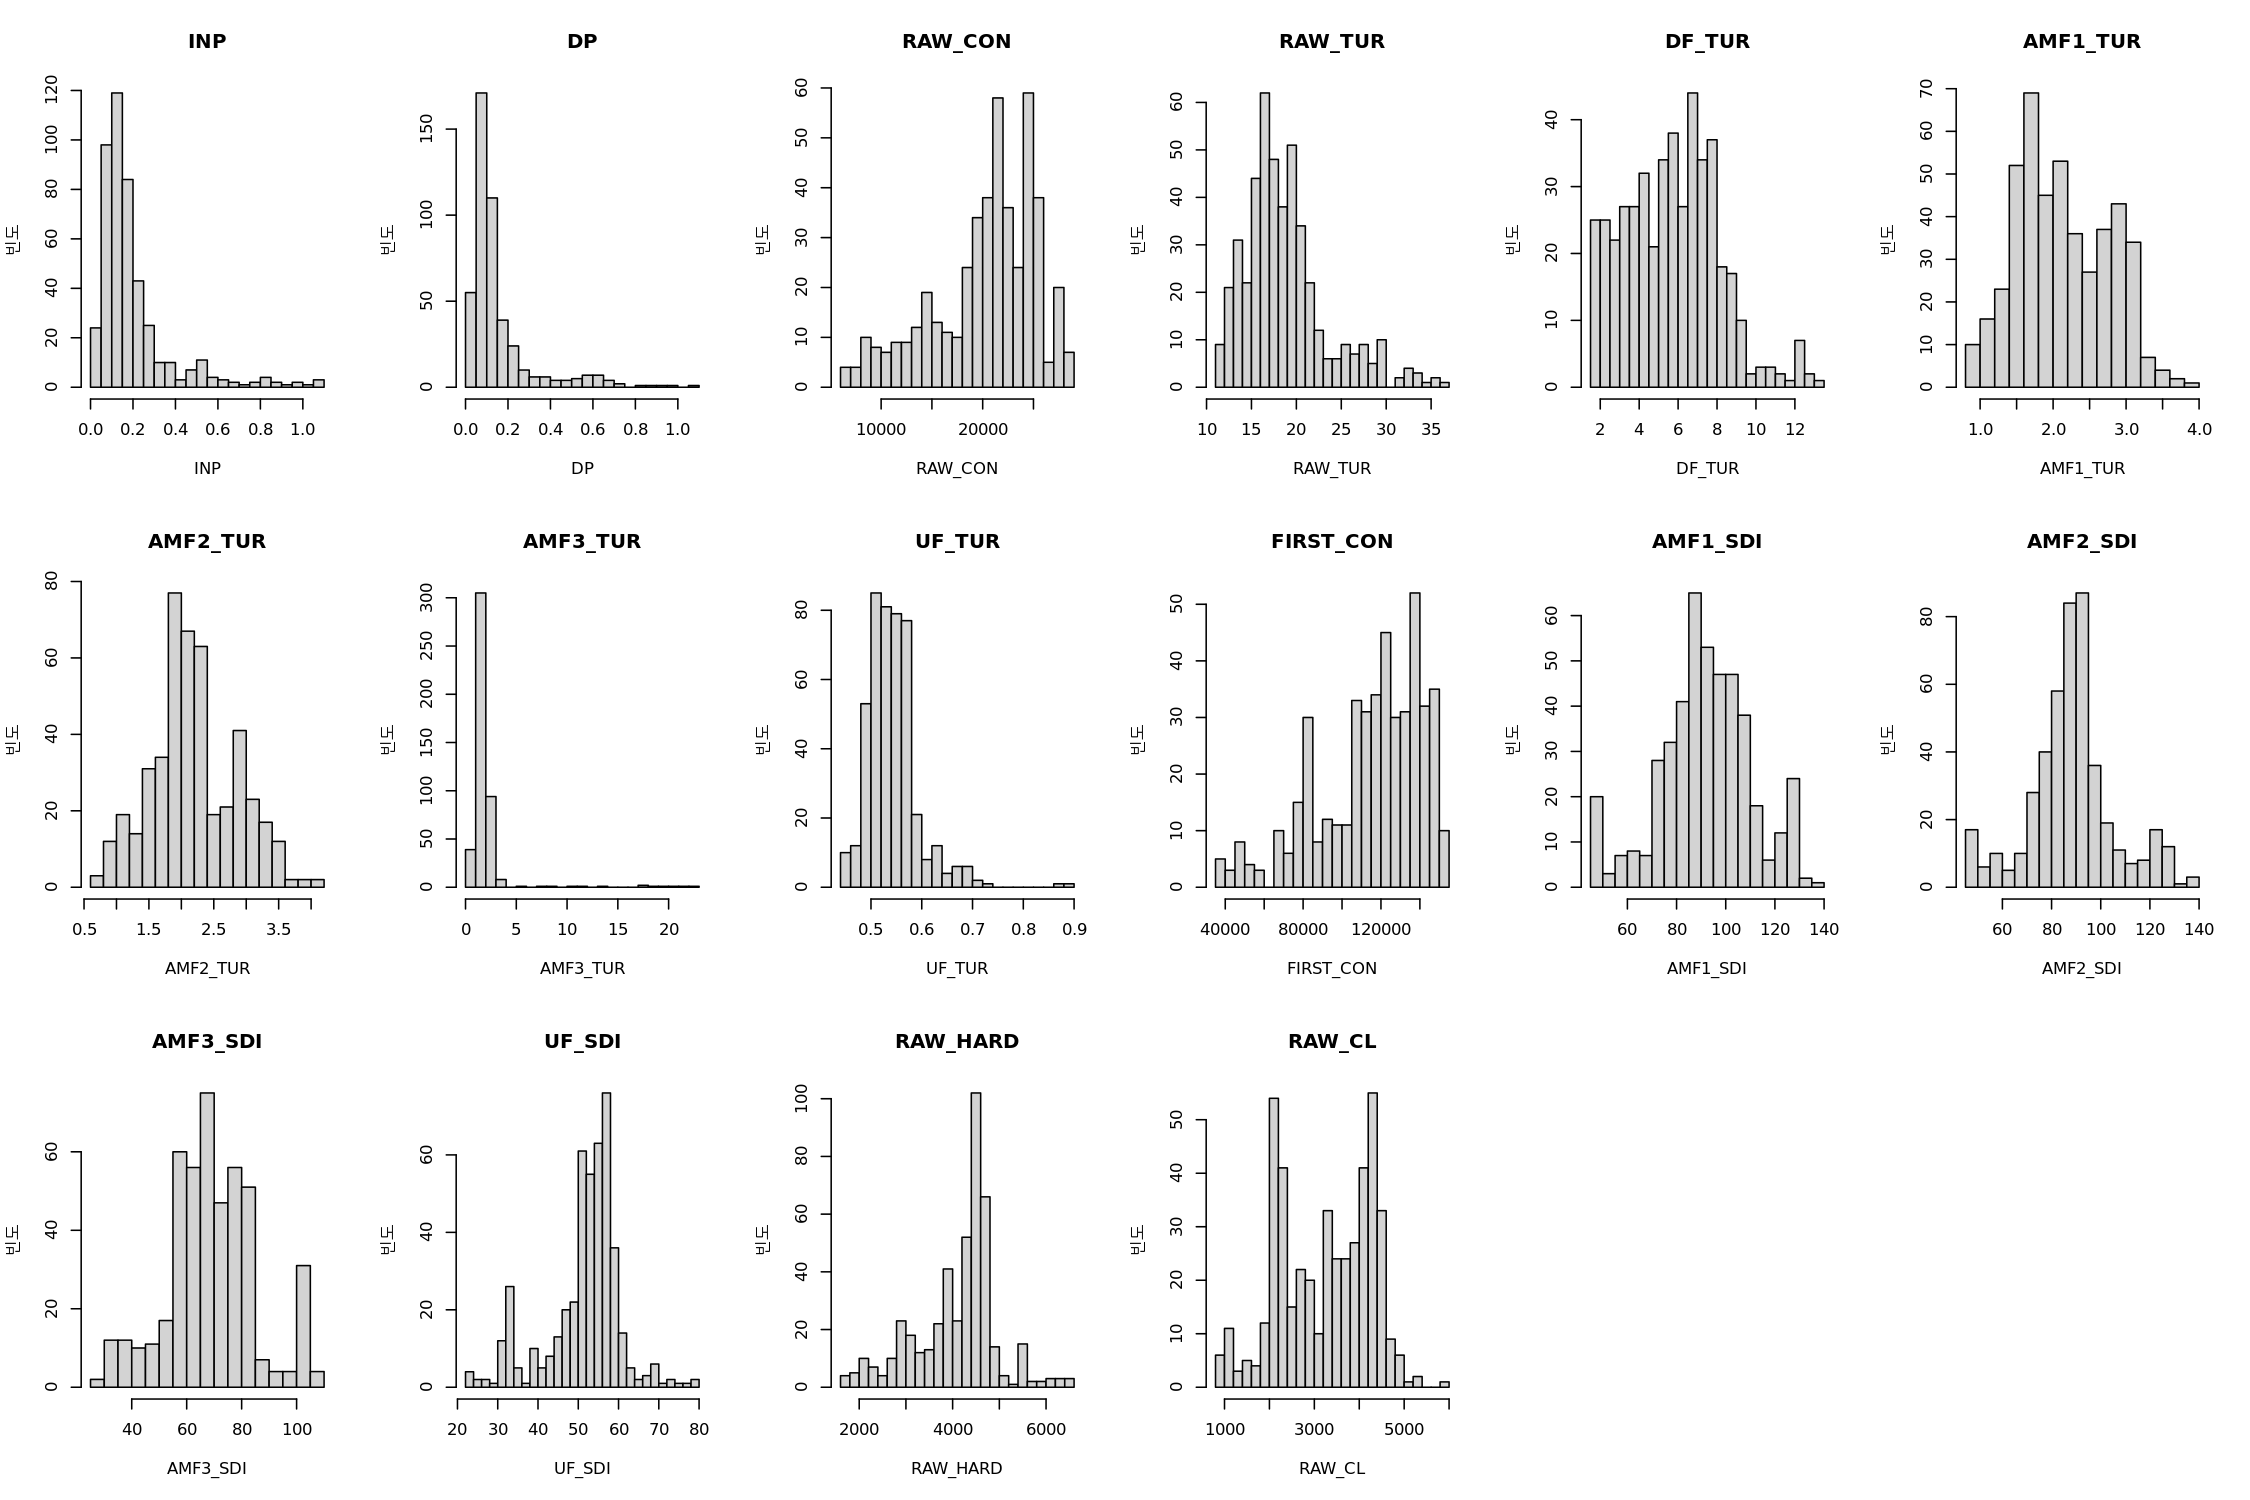

In [9]:
# 히스토그램(독립변수)
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)
par(mfrow = c(3, 6))

col.names <- names(data_df)

for(h.i in 2:ncol(data_df)) {
    hist(data_df[, h.i], breaks = 20, 
    xlab = names(data_df)[h.i], ylab = '빈도', main = col.names[h.i])
}

par(mfrow = c(1,1))

독립변수를 히스토그램으로 나타낸 결과입니다. INP(24시간 기준 유입압 변화량), DP(24시간 기준 차압 변화량), AMF3_TUR(24시간 기준 누적 AMF3기 탁도) 등은 다른 변수에 비해 치우친 모습을 볼 수 있습니다.

## 종속변수 및 독립변수 간 탐색적 분석

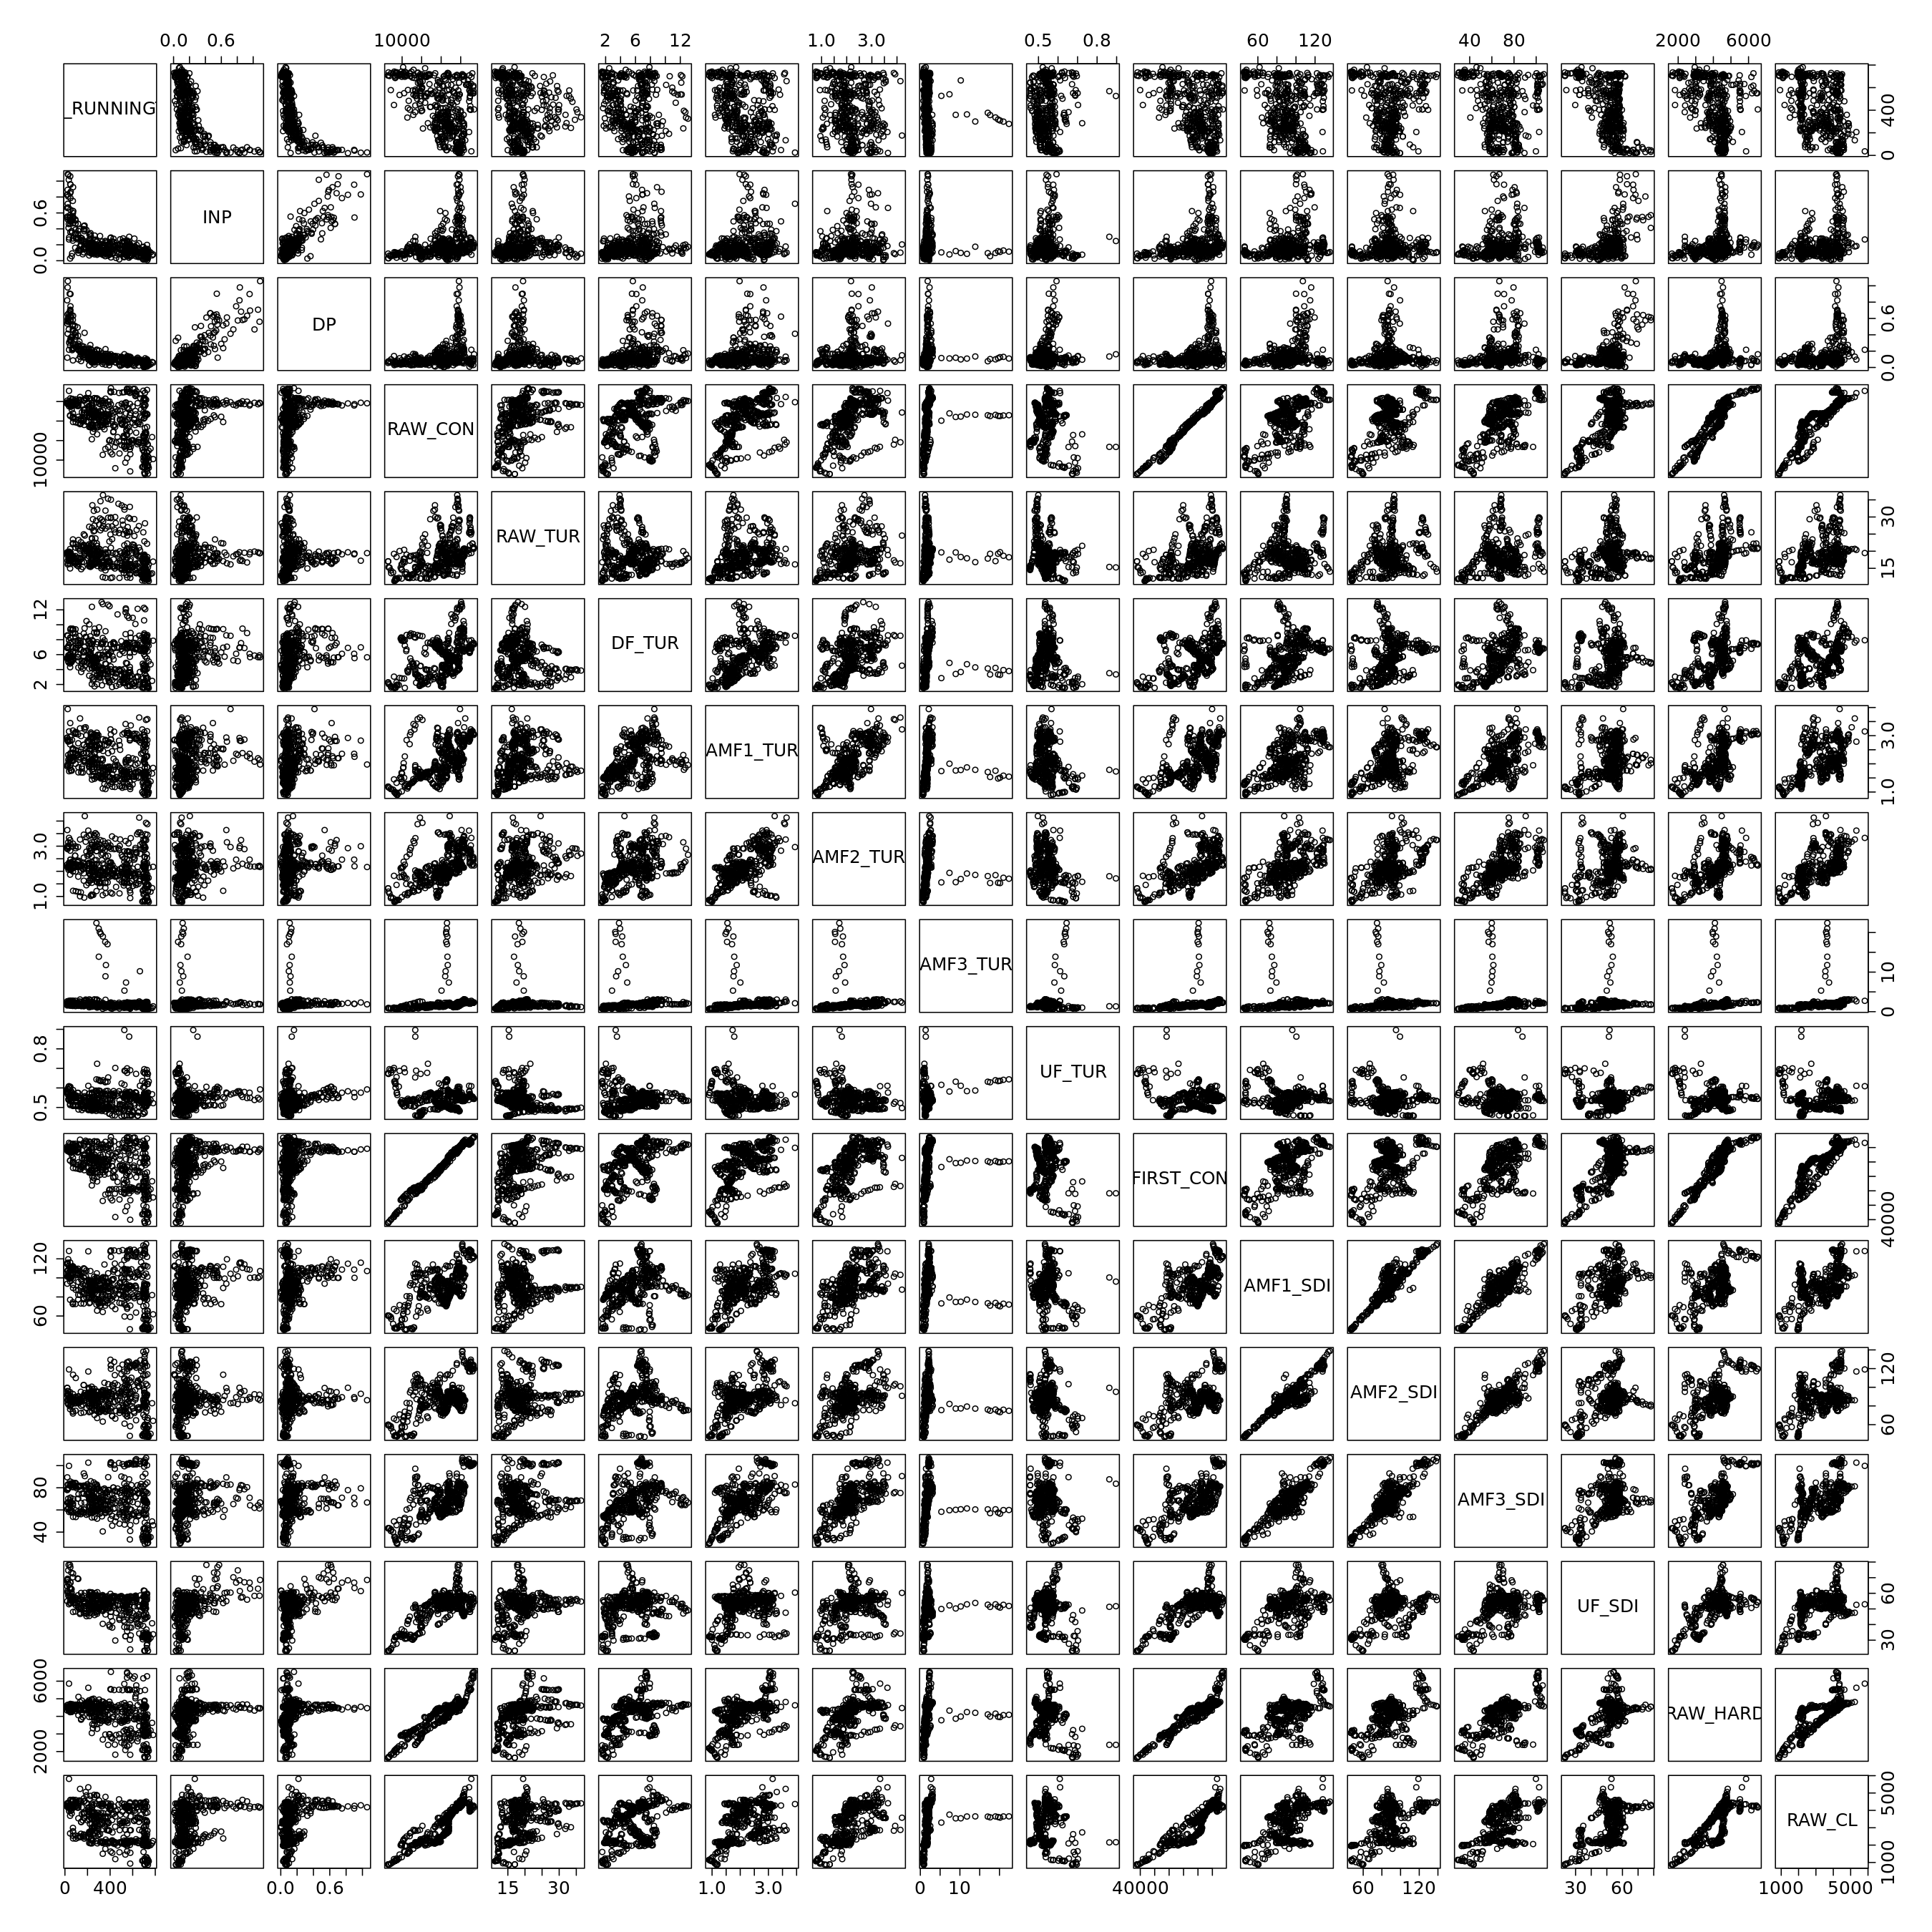

In [10]:
# 산점도(종속변수 및 독립변수) 
options(repr.plot.width = 18, repr.plot.height = 18)
plot(data_df, cex.axis = 1.5, cex.labels = 1.5)

종속변수와 독립변수 간의 관계를 살펴보기 위해 산점도를 그렸습니다. 산점도를 통해 아래 정보를 알 수 있습니다.  
* INP(24시간 기준 유입압 변화량), DP(24시간 기준 차압 변화량)의 값이 커질수록 CUM_RUNNINGTIME(1회 연속운전시간)의 값이 작아집니다.
* INP(24시간 기준 유입압 변화량)과 DP(24시간 기준 차압 변화량)은 선형적인 관계를 가집니다.
* AMF2_SDI(24시간 기준 누적 AMF2기 SDI)와 AMF3_SDI(24시간 기준 누적 AMF3기 SDI)는 선형적인 관계를 가집니다.

데이터 전처리에 앞서, RAW_TUR 이외에 나머지 공정 탁도는 경험상 의미가 없는 변수이므로 DF_TUR, AMF1_TUR, AMF2_TUR, AMF3_TUR, UF_TUR를 임의로 제외합니다.  

In [11]:
data_df <- data_df %>% select(-c(DF_TUR, AMF1_TUR, AMF2_TUR, AMF3_TUR, UF_TUR))

# 데이터 전처리

## 데이터 분할

In [12]:
# 7:3 비율 분할
train_index <- round(nrow(data_df) * 0.7)

train_df <- data.frame(data_df[1:train_index, ])  # train dataset
test_df <- data.frame(data_df[-c(1:train_index), ])  # test dataset

# 데이터 구조 확인
str(train_df)
str(test_df)

'data.frame':	321 obs. of  12 variables:
 $ CUM_RUNNINGTIME: num  694 724 622 294 390 167 474 239 167 300 ...
 $ INP            : num  0.0747 0.0804 0.1325 0.1755 0.1089 ...
 $ DP             : num  0.0365 0.036 0.0907 0.0992 0.0591 ...
 $ RAW_CON        : num  27754 11939 18963 20613 21689 ...
 $ RAW_TUR        : num  25.5 17.2 15.8 20.2 16.8 ...
 $ FIRST_CON      : num  149510 79216 108443 116935 123059 ...
 $ AMF1_SDI       : num  126 80.8 100.4 77.1 95.6 ...
 $ AMF2_SDI       : num  119.6 83 96.9 83.7 94.6 ...
 $ AMF3_SDI       : num  102.2 61.6 71.6 61.3 78 ...
 $ UF_SDI         : num  50.6 32.1 58 52.9 54.9 ...
 $ RAW_HARD       : num  6162 3130 4319 4426 4521 ...
 $ RAW_CL         : num  4007 2512 2167 2546 2859 ...
'data.frame':	138 obs. of  12 variables:
 $ CUM_RUNNINGTIME: num  555 431 237 311 485 446 503 213 431 527 ...
 $ INP            : num  0.133 0.171 0.223 0.114 0.149 ...
 $ DP             : num  0.115 0.135 0.1757 0.0787 0.0841 ...
 $ RAW_CON        : num  18149 18764

분석에 사용할 data_df를 7:3의 비율로 나누었습니다. 전체 데이터 중 약 70%인 321개는 train dataset으로 사용하고, 나머지 30%인 138개는 test dataset으로 사용합니다. 

In [13]:
# 데이터 구조 확인
summary(train_df)

 CUM_RUNNINGTIME      INP                 DP              RAW_CON     
 Min.   : 20.0   Min.   :0.007644   Min.   :0.004642   Min.   : 6437  
 1st Qu.:215.0   1st Qu.:0.099574   1st Qu.:0.066839   1st Qu.:17326  
 Median :370.0   Median :0.150180   Median :0.100408   Median :21421  
 Mean   :397.4   Mean   :0.205981   Mean   :0.152131   Mean   :20187  
 3rd Qu.:618.0   3rd Qu.:0.225941   3rd Qu.:0.161000   3rd Qu.:24171  
 Max.   :772.0   Max.   :1.086923   Max.   :1.056923   Max.   :28278  
    RAW_TUR        FIRST_CON         AMF1_SDI         AMF2_SDI     
 Min.   :11.28   Min.   : 35534   Min.   : 45.68   Min.   : 46.90  
 1st Qu.:15.58   1st Qu.: 99286   1st Qu.: 80.55   1st Qu.: 79.38  
 Median :17.90   Median :120631   Median : 90.54   Median : 88.04  
 Mean   :18.76   Mean   :114617   Mean   : 91.27   Mean   : 88.13  
 3rd Qu.:20.66   3rd Qu.:136257   3rd Qu.:102.53   3rd Qu.: 94.75  
 Max.   :36.39   Max.   :154101   Max.   :135.60   Max.   :138.88  
    AMF3_SDI          UF_SD

In [14]:
# 데이터 구조 확인
summary(test_df)

 CUM_RUNNINGTIME      INP                DP             RAW_CON     
 Min.   : 34.0   Min.   :0.01948   Min.   :0.02308   Min.   : 6423  
 1st Qu.:239.0   1st Qu.:0.09577   1st Qu.:0.07389   1st Qu.:18555  
 Median :430.5   Median :0.13782   Median :0.10338   Median :21679  
 Mean   :413.3   Mean   :0.18608   Mean   :0.15852   Mean   :20498  
 3rd Qu.:575.0   3rd Qu.:0.19635   3rd Qu.:0.15791   3rd Qu.:24321  
 Max.   :781.0   Max.   :1.06085   Max.   :0.89878   Max.   :28427  
    RAW_TUR        FIRST_CON         AMF1_SDI         AMF2_SDI     
 Min.   :11.45   Min.   : 35451   Min.   : 45.41   Min.   : 47.24  
 1st Qu.:15.81   1st Qu.:104634   1st Qu.: 81.83   1st Qu.: 80.66  
 Median :17.82   Median :123401   Median : 92.55   Median : 87.95  
 Mean   :18.73   Mean   :116125   Mean   : 92.65   Mean   : 88.62  
 3rd Qu.:20.39   3rd Qu.:137244   3rd Qu.:104.11   3rd Qu.: 95.42  
 Max.   :35.05   Max.   :154629   Max.   :134.01   Max.   :138.07  
    AMF3_SDI          UF_SDI         RAW_

모델은 train dataset을 기준으로 데이터의 특성을 파악하기 때문에, train dataset과 test dataset의 분포가 다르면 모델의 예측 성능이 떨어질 수 있습니다.  
따라서 train, test dataset의 분포를 그래프로 확인하고 train, test dataset이 잘 구성되었는지 확인합니다.  

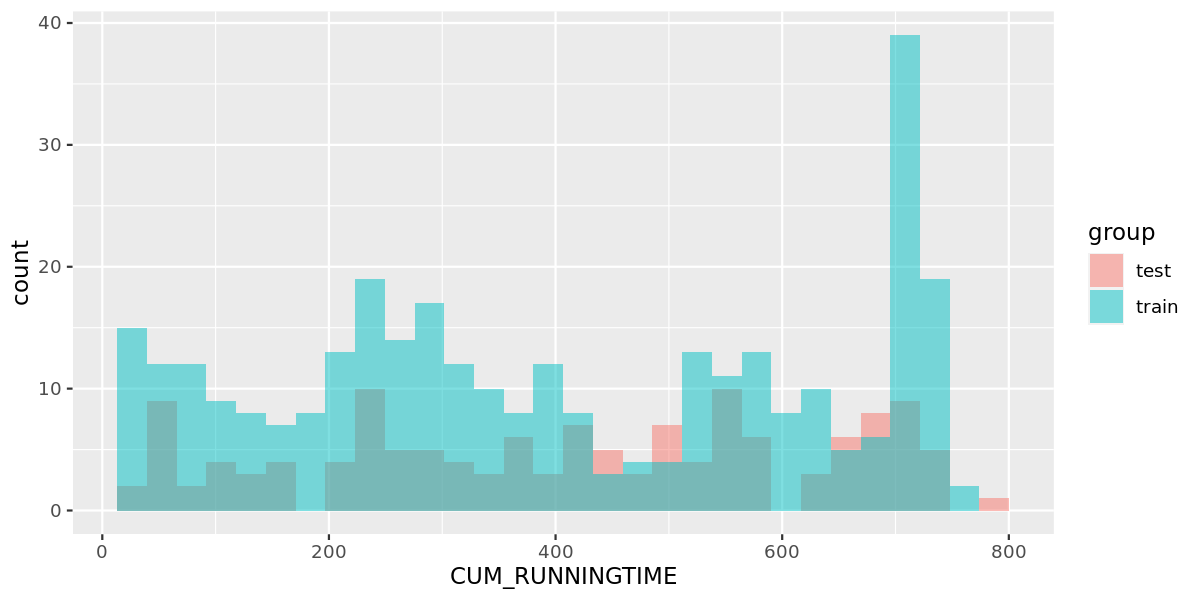

In [15]:
# train, test dataset 분포 비교
total_df <- rbind(mutate(train_df, group = 'train'), mutate(test_df, group = 'test'))

# 종속변수(CUM_RUNNINGTIME)
options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(total_df, aes(x = CUM_RUNNINGTIME, fill = group)) + geom_histogram(alpha = 0.5, position = 'identity', bins = 30) 

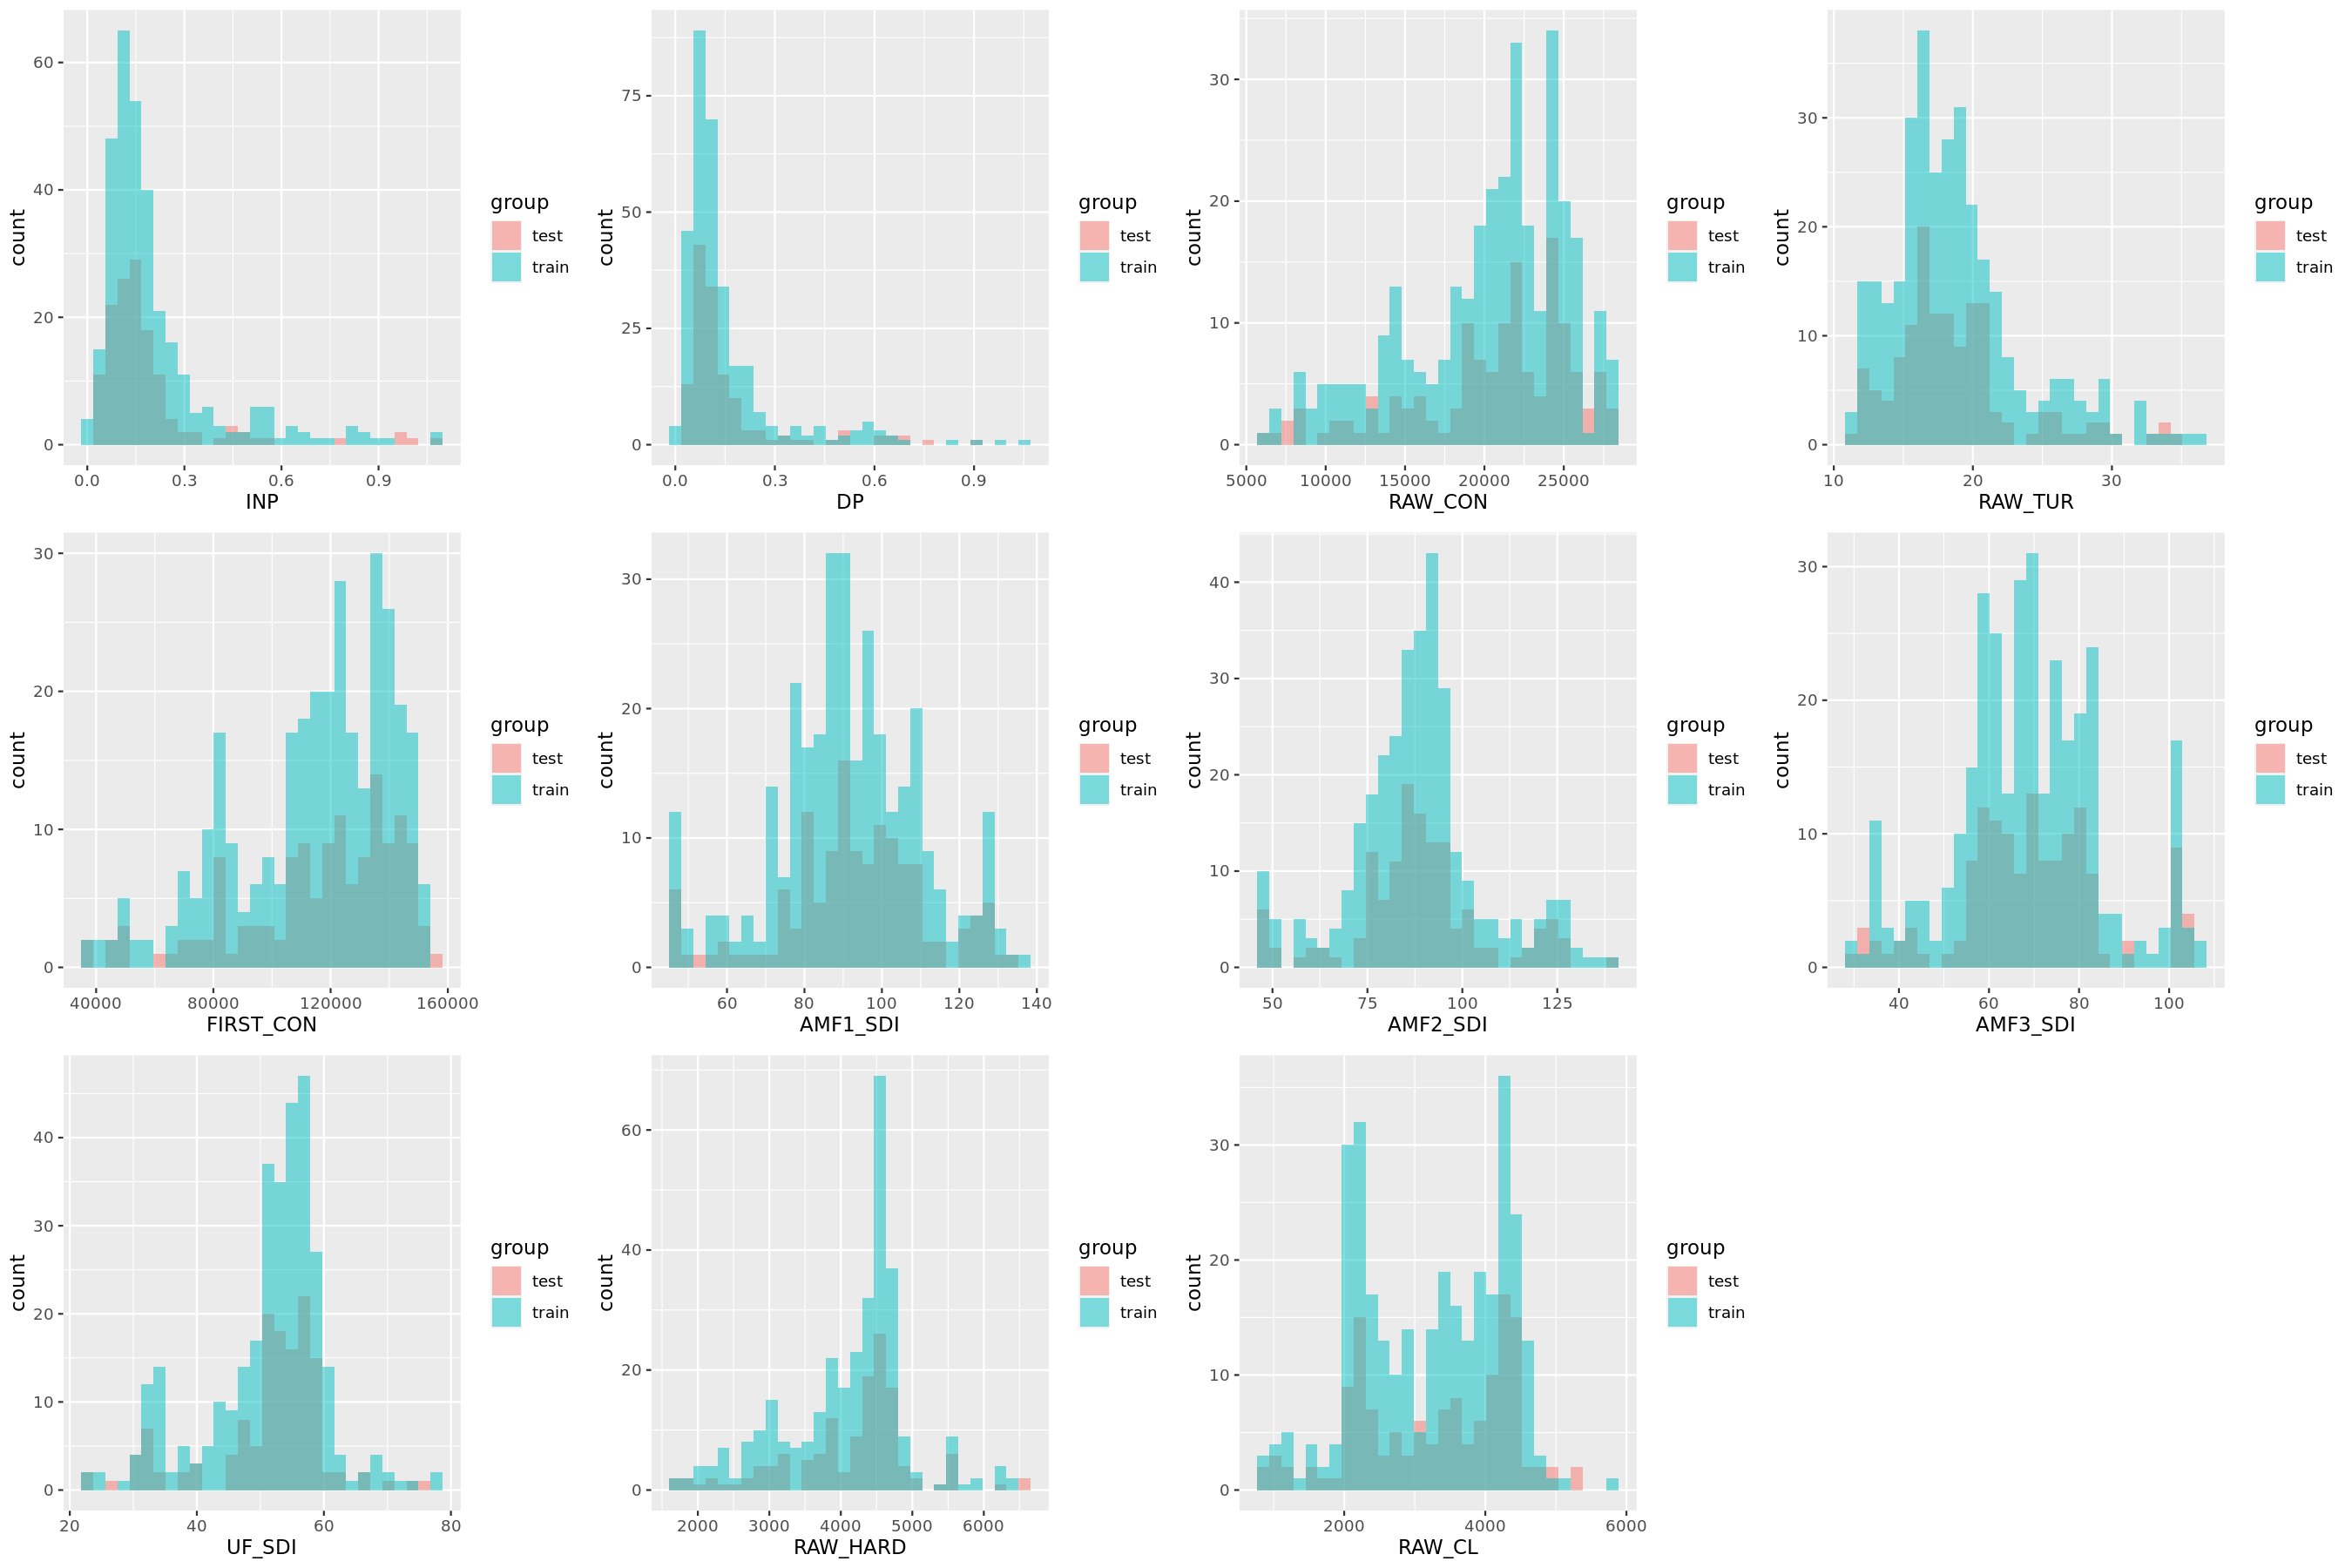

In [16]:
# train, test dataset 분포 비교

# 독립변수(INP, DP, RAW_CON, RAW_TUR, FIRST_CON, AMF1_SID, AMF2_SDI, AMF3_SDI, UF_SDI, RAW_HARD, RAW_CL)
plot_list <- vector(mode = 'list', length = (ncol(total_df)-2))
for(h.i in 2:(ncol(total_df)-1)){
        plot_list[[h.i-1]] <- ggplot(total_df, aes(x = .data[[names(total_df)[h.i]]], fill = group)) + geom_histogram(alpha = 0.5, position = 'identity', bins = 30) 
}

options(repr.plot.width = 18, repr.plot.height = 12)
grid.arrange(grobs = plot_list, ncol = 4)

train, test dataset의 독립변수 분포를 살펴보니 두 그룹 간 분포가 비슷한 것을 확인할 수 있습니다. 따라서 train, test dataset이 잘 구성되었다고 할 수 있습니다.

## 데이터 스케일링

[Standardization(표준화)]  
>* $ Z = {X-\mu \over \sigma} $ &nbsp;&nbsp;&nbsp; ($ \mu $는 평균, $ \sigma $는 표준편차)
>* 표준화는 Z-점수(Z-score)를 통해 데이터의 평균, 표준편차를 기준으로 값을 조정함  .
   여기서, Z-점수란 각 값이 평균에서 표준편차의 몇 배 정도 떨어져 있는지를 나타내는 척도를 의미함.
>* 평균을 0으로 하고 결과 분포에 단위 표준편차 1을 사용함.
>*  표준화의 경우 값이 특정범위로 제한되지 않음.

In [17]:
# 데이터 스케일링(표준화)
train_scaling_x_df <- scale(select(train_df, -CUM_RUNNINGTIME))
train_scaling_df <- data.frame(CUM_RUNNINGTIME = train_df$CUM_RUNNINGTIME, train_scaling_x_df)

head(train_scaling_df, n = 10)

,CUM_RUNNINGTIME,INP,DP,RAW_CON,RAW_TUR,FIRST_CON,AMF1_SDI,AMF2_SDI,AMF3_SDI,UF_SDI,RAW_HARD,RAW_CL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,694,-0.7279861,-0.72863472,1.50637261,1.4203051,1.30400264,1.86108439,1.842708225,2.08500302,-0.07724198,2.4063730,0.7884895
2,724,-0.6964378,-0.73189397,-1.64217681,-0.3253948,-1.32299603,-0.56091289,-0.302045367,-0.45197904,-2.07862945,-1.1162890,-0.6975465
3,622,-0.4072384,-0.38720317,-0.24366543,-0.6322472,-0.23074007,0.49005023,0.516043732,0.17594422,0.71955363,0.2652819,-1.0408426
4,294,-0.1689626,-0.33359570,0.08472762,0.3080310,0.08663526,-0.75694162,-0.260527583,-0.46952297,0.16257570,0.3893578,-0.6635438
5,390,-0.5381991,-0.58628871,0.29904730,-0.4158314,0.31550984,0.23425940,0.376601450,0.57476017,0.37799474,0.5003083,-0.3527015
6,167,0.1846593,0.01034150,0.37995451,1.2991978,0.36381129,-0.31513348,-0.002211307,1.50728616,0.76243068,0.5587636,0.3596401
7,474,-0.6817363,-0.49433929,0.77102805,3.1756643,0.85513170,-0.05498402,0.301252567,-0.05979042,0.41392811,0.6222242,1.1036608
8,239,-0.3152932,-0.21509596,0.87973382,1.6900377,0.94611408,-0.25266809,0.061228862,0.01892185,0.09751861,0.9777781,1.1709521
9,167,-0.3094247,0.09183314,0.54209406,0.5176841,0.55467858,0.51924119,0.837600537,0.36241162,0.39593879,0.6229999,0.5846743


변수 단위에 차이가 있으므로 스케일링을 진행합니다. 스케일링은 독립변수에만 적용합니다.  
본 과제에서는 평균과 표준편차를 사용하여 데이터를 표준화합니다. test dataset에 동일한 스케일을 적용하기 위해 train dataset의 평균과 표준편차를 저장합니다.

In [18]:
# train dataset의 평균 및 표준편차 저장
train.mean <- apply(select(train_df, -CUM_RUNNINGTIME), 2, mean)
train.sd <- apply(select(train_df, -CUM_RUNNINGTIME), 2, sd)

# train dataset의 평균 및 표준편차를 이용하여 test dataset 표준화
test_scaling_x_df <- sweep(sweep(select(test_df, -CUM_RUNNINGTIME), 2, train.mean, '-'), 2, train.sd, '/')
test_scaling_df <- data.frame(CUM_RUNNINGTIME = test_df$CUM_RUNNINGTIME, test_scaling_x_df)
head(test_scaling_df, n = 10)

,CUM_RUNNINGTIME,INP,DP,RAW_CON,RAW_TUR,FIRST_CON,AMF1_SDI,AMF2_SDI,AMF3_SDI,UF_SDI,RAW_HARD,RAW_CL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
322,555,-0.40304011,-0.2337745,-0.40589606,-0.8228211,-0.38388248,0.94448583,0.8648418,0.67774258,0.48600909,0.1016611,-1.11198645
323,431,-0.19501458,-0.1077153,-0.28338079,-0.6623297,-0.26832762,0.41038798,0.4270973,0.10356641,0.73233877,0.3461209,-1.04439501
324,237,0.09177895,0.1484723,-0.19407092,0.3429296,-0.19920278,-0.01190103,0.7313683,-0.71990540,-0.10626372,0.2736195,-0.82537203
325,311,-0.50993980,-0.4625662,0.17159622,0.3799120,0.19751599,-0.88175850,-0.8355259,-0.27293249,0.32251877,0.4422561,-0.57773370
326,485,-0.31487988,-0.4284812,0.31036259,-0.4566817,0.33729062,0.20016420,0.3474020,0.42439088,0.54155789,0.4818261,-0.35272725
327,446,-0.05007173,-0.5448736,0.43608316,1.4116420,0.48456024,-0.21080461,0.1465178,0.49705529,0.72884529,0.5067129,0.43498975
328,503,-0.40996925,-0.2565540,0.84458764,3.0750463,0.93488060,-0.06603604,0.2811011,-0.03553579,0.52590928,0.6996300,1.18180668
329,213,-0.28464759,0.1170203,0.65792810,0.4919719,0.71145031,0.23225666,0.5828581,0.47634231,0.15400816,0.8143323,0.81509971
330,431,-0.34322870,-0.2445431,0.38635233,-0.2449254,0.38366232,-0.53107618,-0.2503939,-0.48792905,0.03755964,0.3357458,0.58218422


train dataset의 평균과 표준편차를 사용하여 test dataset도 표준화를 진행합니다. 마찬가지로 독립변수에만 스케일링을 적용합니다.

## 변수 선택

**XGBoost(eXtreme Gradient Boosting)** 을 활용하여 변수 선택을 합니다.  
XGBoost는 부스팅(Boosting) 모델 중 하나입니다. 부스팅은 예측 모형을 여러 개 결합하여 더욱 정확한 예측 모형을 만드는 방법입니다. 여러 개의 결정 트리(Decision Tree)를 사용하여 예측을 하고, 잘못 분류된 예측값에 대해 가중치를 부여하여 다음 예측 성능이 더 좋아지도록 합니다. 잘못 예측된 데이터에 가중치를 증가시킴으로써, 현재 성능이 제일 떨어지는 데이터에 대해 더 집중해서 학습을 하도록 하는 효과를 가져옵니다.

XGBoost는 연속형 변수와 범주형 변수 모두 사용 가능합니다.

In [19]:
# XGBoost
# data: 독립변수(matrix type), label: 종속변수, nrounds: 부스팅 반복 횟수, objective: 목적함수(Objective Function)
xgb <- xgboost(data = as.matrix(train_scaling_df[, -1]), label = train_scaling_df[, 1],
              nrounds = 10, objective = 'reg:squarederror')

[1]	train-rmse:331.385461 
[2]	train-rmse:240.865471 
[3]	train-rmse:176.388021 
[4]	train-rmse:131.265280 
[5]	train-rmse:99.286021 
[6]	train-rmse:77.641549 
[7]	train-rmse:61.612257 
[8]	train-rmse:50.537265 
[9]	train-rmse:41.149868 
[10]	train-rmse:35.113029 


In [20]:
# 변수 중요도 파악
importance_matrix <- xgb.importance(model = xgb)
importance_matrix <- importance_matrix[order(importance_matrix$Gain, decreasing = TRUE), ]

importance_matrix

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
DP,0.745332752,0.33923459,0.15434084
RAW_TUR,0.076363970,0.10505405,0.14147910
UF_SDI,0.048650415,0.10838446,0.09646302
FIRST_CON,0.041156658,0.05346188,0.04823151
RAW_CON,0.025685013,0.07052293,0.09003215
INP,0.017140654,0.07811861,0.16398714
RAW_HARD,0.016465978,0.06871166,0.07717042
AMF3_SDI,0.014031564,0.05901256,0.06752412
AMF1_SDI,0.011459700,0.06701724,0.08681672


변수중요도를 파악합니다. Gain, Cover, Frequency는 변수들이 예측 성능에 얼마나 기여했는지를 수치화한 값입니다.
* Gain: 각 변수가 모형의 학습 손실(train loss)을 최소화하는데 기여한 정도. 값이 클수록 해당 변수가 모델에 중요하게 사용됨을 의미
* Cover: 트리에서 각 변수가 분기하는 노드의 수를 누적한 값. 값이 클수록 해당 변수가 모델에 중요하게 사용됨을 의미
* Frequency: 각 변수가 모형에서 사용된 빈도. 값이 클수록 해당 변수가 모델에 중요하게 사용됨을 의미

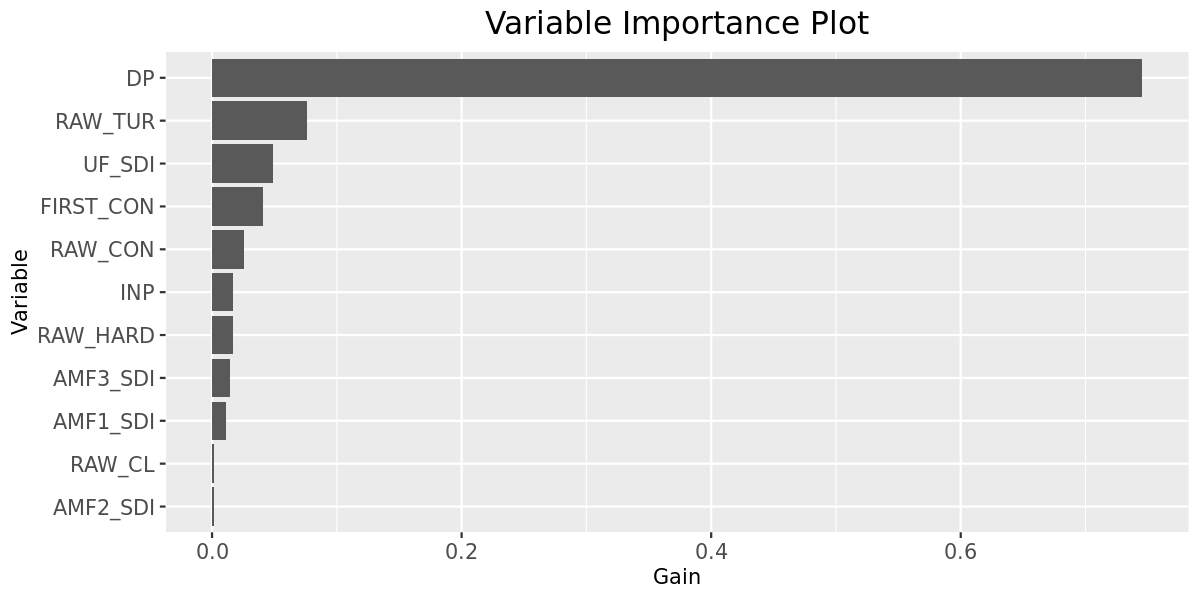

In [21]:
# 변수 중요도 시각화
options(repr.plot.width = 8, repr.plot.height = 4)
ggplot(data = importance_matrix, aes(x = Gain, y = reorder(Feature, Gain))) +
  geom_bar(stat = 'identity') +
  labs(x = 'Gain', y = 'Variable') +
  ggtitle('Variable Importance Plot') + 
  theme(strip.text.x = element_text(size = 10), axis.title = element_text(size = 10), axis.text = element_text(size = 10), plot.title = element_text(hjust = 0.5, size = 15))

변수 중요도 중 Gain을 기준으로 변수 중요도를 막대 그래프로 그렸습니다.

In [22]:
# 변수 선택
select.num <- 7  # 사용자 정의
select.var <- importance_matrix$Feature[1:select.num]

select.var

[1] "DP"        "RAW_TUR"   "UF_SDI"    "FIRST_CON" "RAW_CON"   "INP"      
[7] "RAW_HARD"

Gain을 기준으로 상위 7개 변수들을 선택하겠습니다. 선택된 변수는 DP, RAW_TUR, UF_SDI, FIRST_CON, RAW_CON, INP, RAW_HARD입니다.  

# 모델 학습

In [23]:
# 분석 결과 재생성을 위해 seed 고정
set.seed(1234)

## Neural Network

**[신경망(Neural Network)]**
  - 생물학적 신경망의 구조로부터 착안된 학습 알고리즘
  - 반복적인 학습과정을 거쳐 데이터가 가진 패턴을 찾아내고 이를 일반화함으로써 향후를 예측하는 기법
  - 입력 신호를 더 잘 표현하기 위해 입력 노드와 출력 노드 사이에 은닉층(hidden layer)을 가짐.

In [24]:
# 종속변수 설정
var.y <- 'CUM_RUNNINGTIME'

# 모형식 설정
formula.x <- paste(var.y, '~', paste(select.var, collapse = ' + '))

In [25]:
# 모델 생성(은닉 노드 1)
model_nn_hidden1 <- neuralnet(formula = as.formula(formula.x), hidden = c(1), data = train_scaling_df, threshold = 50)

# 모델 생성(은닉 노드 5)
model_nn_hidden5 <- neuralnet(formula = as.formula(formula.x), hidden = c(5), data = train_scaling_df, threshold = 50)

# 모델 생성(은닉 노드 15)
model_nn_hidden15 <- neuralnet(formula = as.formula(formula.x), hidden = c(15), data = train_scaling_df, threshold = 50)

Loading required package: scales



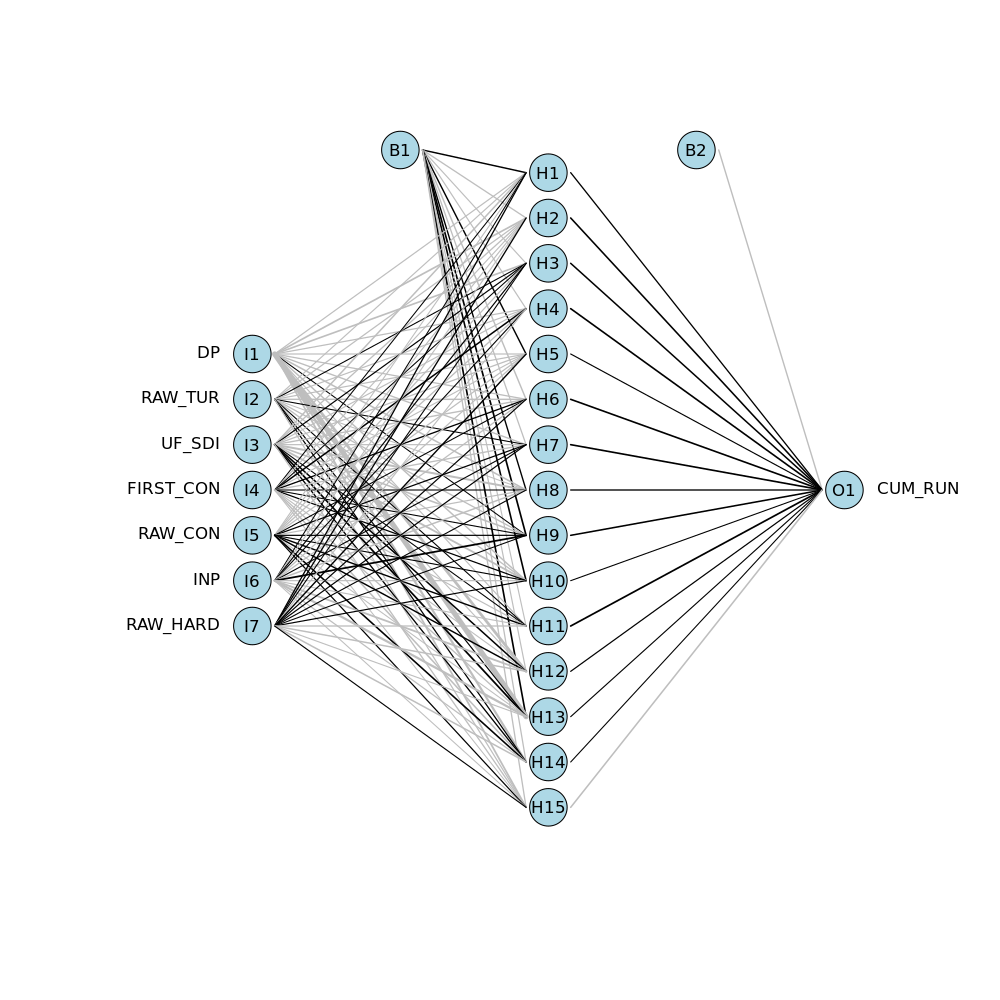

In [26]:
# 그래프 확인(은닉 노드 15)
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
plot_nnet_fn(model_nn_hidden15)

은닉 노드를 각각 1개, 5개, 15개 가진 신경망 모델을 생성했습니다. 신경망 모델 구조를 확인하기 위해 은닉 노드가 15개인 모델에 대해 그래프를 그렸습니다.

In [27]:
# train dataset을 이용한 예측
# 은닉 노드 1
pred_hidden1_result <- compute(model_nn_hidden1, train_scaling_df)$net.result  

# 은닉 노드 5
pred_hidden5_result <- compute(model_nn_hidden5, train_scaling_df)$net.result

# 은닉 노드 15
pred_hidden15_result <- compute(model_nn_hidden15, train_scaling_df)$net.result

test data로 모형 예측 성능을 살펴보기에 앞서, 모델링을 할 때 사용한 train dataset으로 예측 성능을 살펴봅니다.
만약 train dataset으로도 예측 결과가 좋지 않다면 X 인자가 Y 인자를 잘 설명하는지 확인해야 합니다.

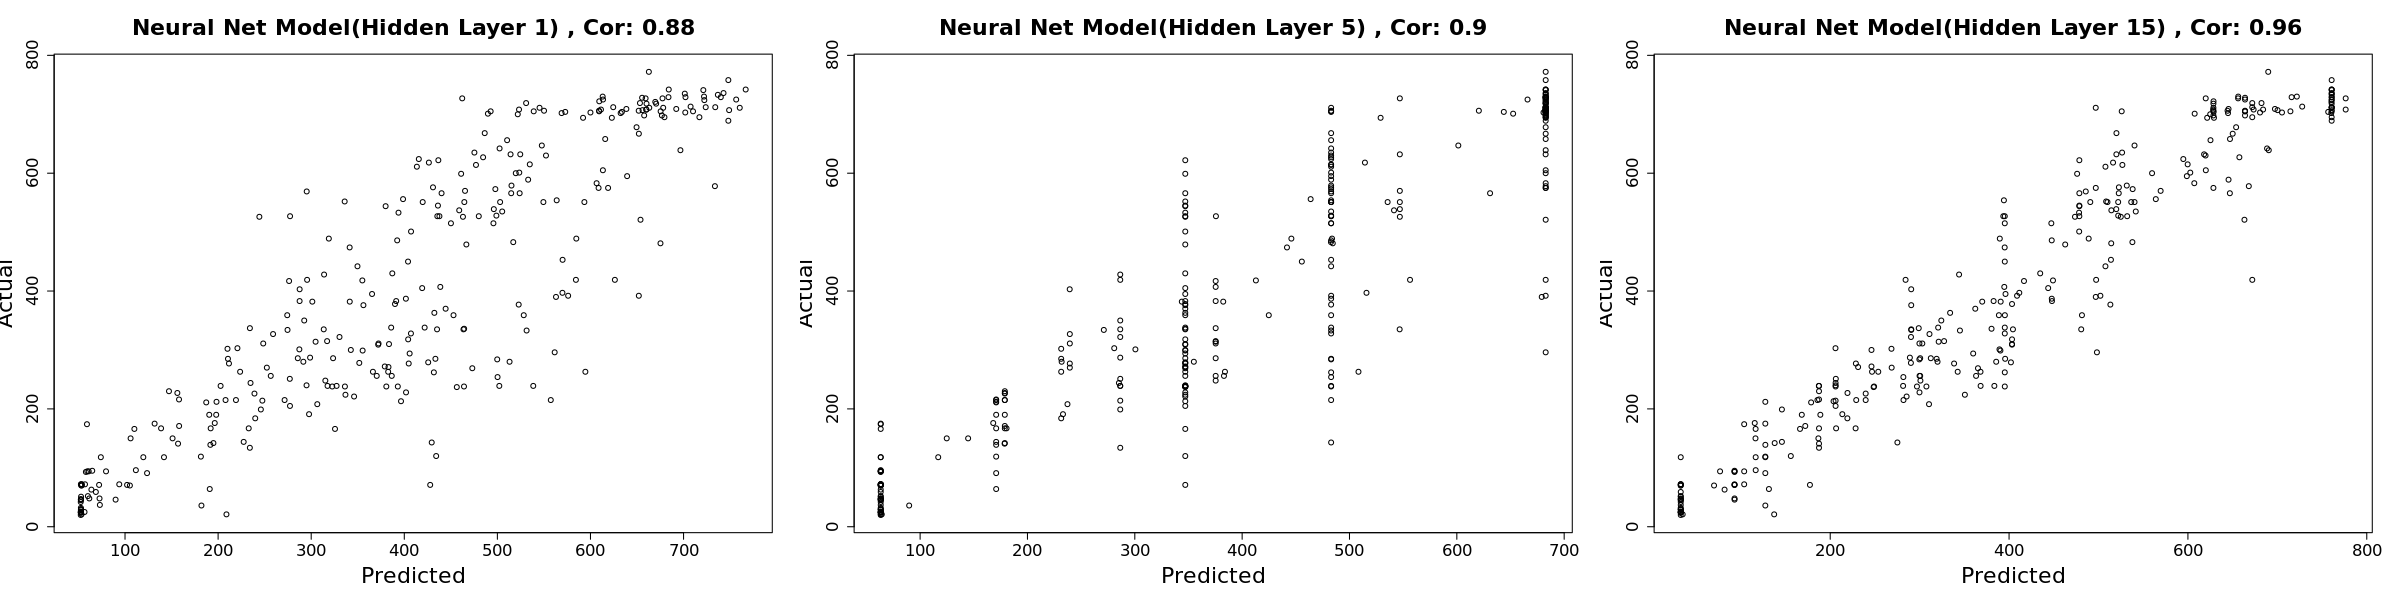

In [28]:
# 예측값과 실제값 비교(산점도)
options(repr.plot.width = 24, repr.plot.height = 6)
par(mfrow = c(1, 3))
plot(x = pred_hidden1_result, y = train_df$CUM_RUNNINGTIME,
     xlab = "Predicted", ylab = "Actual", cex.lab = 2, cex.main = 2, cex.axis = 1.5,
     main = paste("Neural Net Model(Hidden Layer 1)", ", Cor:", round(cor(pred_hidden1_result, train_scaling_df$CUM_RUNNINGTIME), 2))) 
plot(x = pred_hidden5_result, y = train_df$CUM_RUNNINGTIME,
     xlab = "Predicted", ylab = "Actual", cex.lab = 2, cex.main = 2, cex.axis = 1.5,
     main = paste("Neural Net Model(Hidden Layer 5)", ", Cor:", round(cor(pred_hidden5_result, train_scaling_df$CUM_RUNNINGTIME), 2))) 
plot(x = pred_hidden15_result, y = train_df$CUM_RUNNINGTIME,
     xlab = "Predicted", ylab = "Actual", cex.lab = 2, cex.main = 2, cex.axis = 1.5,
     main = paste("Neural Net Model(Hidden Layer 15)", ", Cor:", round(cor(pred_hidden15_result, train_scaling_df$CUM_RUNNINGTIME), 2)))

In [29]:
# RMSE 계산
data.frame(node1 = round(rmse(actual = train_df$CUM_RUNNINGTIME, predicted = pred_hidden1_result), 2),
           node5 = round(rmse(actual = train_df$CUM_RUNNINGTIME, predicted = pred_hidden5_result), 2),
           node15 = round(rmse(actual = train_df$CUM_RUNNINGTIME, predicted = pred_hidden15_result), 2))

node1,node5,node15
<dbl>,<dbl>,<dbl>
109.3,99.69,63.65


**RMSE(Root Mean Square Error)** 는 평균 제곱근 오차라고 하며, 예측값과 실제값 간의 차(오차)를 제곱하여 평균을 계산한 후 제곱근한 값입니다. 종속변수가 연속형 변수일 때 모델 평가지표로 활용하는데, 값이 작을수록 모델의 예측 성능이 좋다고 판단합니다.

**상관계수(Correlation)** 는 두 변수간의 선형적인 관계의 정도를 나타내는 값입니다. 상관계수는 -1에서 1 사이의 값을 가지는데 양의 상관관계일 경우 양수, 음의 상관관계를 가질 경우 음수의 값을 가집니다. 그리고 값이 클수록 두 변수의 선형적 상관성이 크다고 말할 수 있습니다. 상관계수를 살펴보니 세 모델 모두 0.8 이상으로 예측값과 실제값은 강한 양의 상관관계를 가지고 있다고 할 수 있습니다.  

# 모델 평가

In [30]:
# train dataset을 이용한 예측
# 은닉 노드 1
pred_hidden1_test_result <- compute(model_nn_hidden1, test_scaling_df)$net.result  

# 은닉 노드 5
pred_hidden5_test_result <- compute(model_nn_hidden5, test_scaling_df)$net.result

# 은닉 노드 15
pred_hidden15_test_result <- compute(model_nn_hidden15, test_scaling_df)$net.result

train dataset으로 학습한 모형으로 test dataset을 사용하여 1회 연속운전시간을 예측합니다.

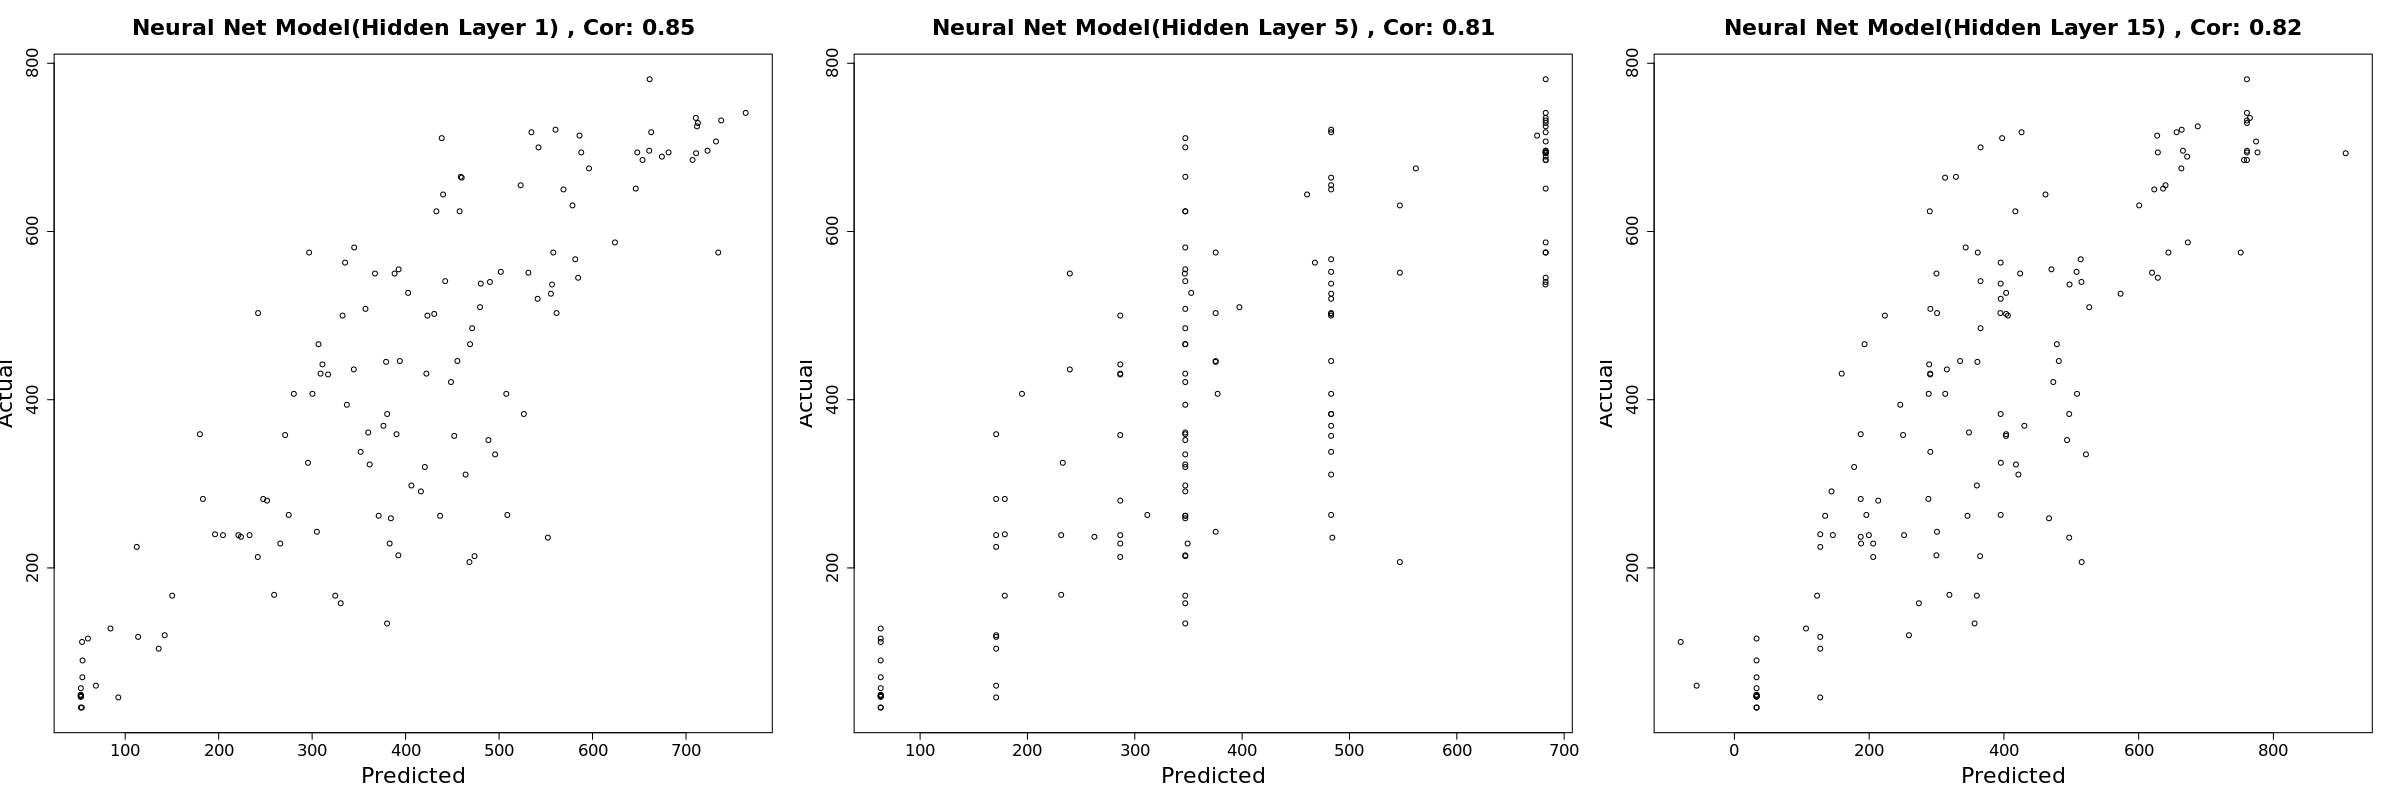

In [31]:
# 평가
# 예측값과 실제값 간의 산점도
options(repr.plot.width = 24, repr.plot.height = 8, repr.plot.res = 100)
par(mfrow = c(1, 3))
plot(pred_hidden1_test_result, test_scaling_df$CUM_RUNNINGTIME, cex.axis = 1.5, cex.main = 2, cex.lab = 2, 
    xlab = "Predicted", ylab = "Actual", main = paste("Neural Net Model(Hidden Layer 1)", ", Cor:", round(cor(pred_hidden1_test_result, test_scaling_df$CUM_RUNNINGTIME), 2)))
plot(pred_hidden5_test_result, test_scaling_df$CUM_RUNNINGTIME, cex.axis = 1.5, cex.main = 2, cex.lab = 2,
    xlab = "Predicted", ylab = "Actual", main = paste("Neural Net Model(Hidden Layer 5)", ", Cor:", round(cor(pred_hidden5_test_result, test_scaling_df$CUM_RUNNINGTIME), 2)))
plot(pred_hidden15_test_result, test_scaling_df$CUM_RUNNINGTIME, cex.axis = 1.5, cex.main = 2, cex.lab = 2,
    xlab = "Predicted", ylab = "Actual", main = paste("Neural Net Model(Hidden Layer 15)", ", Cor:", round(cor(pred_hidden15_test_result, test_scaling_df$CUM_RUNNINGTIME), 2)))

In [32]:
# RMSE 계산
# rmse(actual, predicted): 평균 제곱근 오차(Root Mean Square Error, RMSE) 계산
data.frame(node1 = round(rmse(actual = test_df$CUM_RUNNINGTIME, predicted = pred_hidden1_test_result), 2),
           node5 = round(rmse(actual = test_df$CUM_RUNNINGTIME, predicted = pred_hidden5_test_result), 2),
           node15 = round(rmse(actual = test_df$CUM_RUNNINGTIME, predicted = pred_hidden15_test_result), 2))

node1,node5,node15
<dbl>,<dbl>,<dbl>
113.96,128.45,133.02


RMSE를 기준으로 은닉 노드가 1개, 5개, 15개인 모델을 비교할 때, 은닉 노드가 1개인 신경망 모델의 RMSE가 가장 작아 예측 성능이 가장 우수한 것으로 나타났습니다.  
그 뒤로 은닉 노드가 5개, 15개인 모델 순으로 예측 성능이 좋았습니다.  

마찬가지로 은닉 노드가 1개인 경우 실제값과 예측값 간의 상관계수가 가장 높았고, 그 뒤로 은닉 노드가 15개, 5개인 모델 순으로 실제값과 예측값 간의 상관관계가 강했습니다.

Using  as id variables



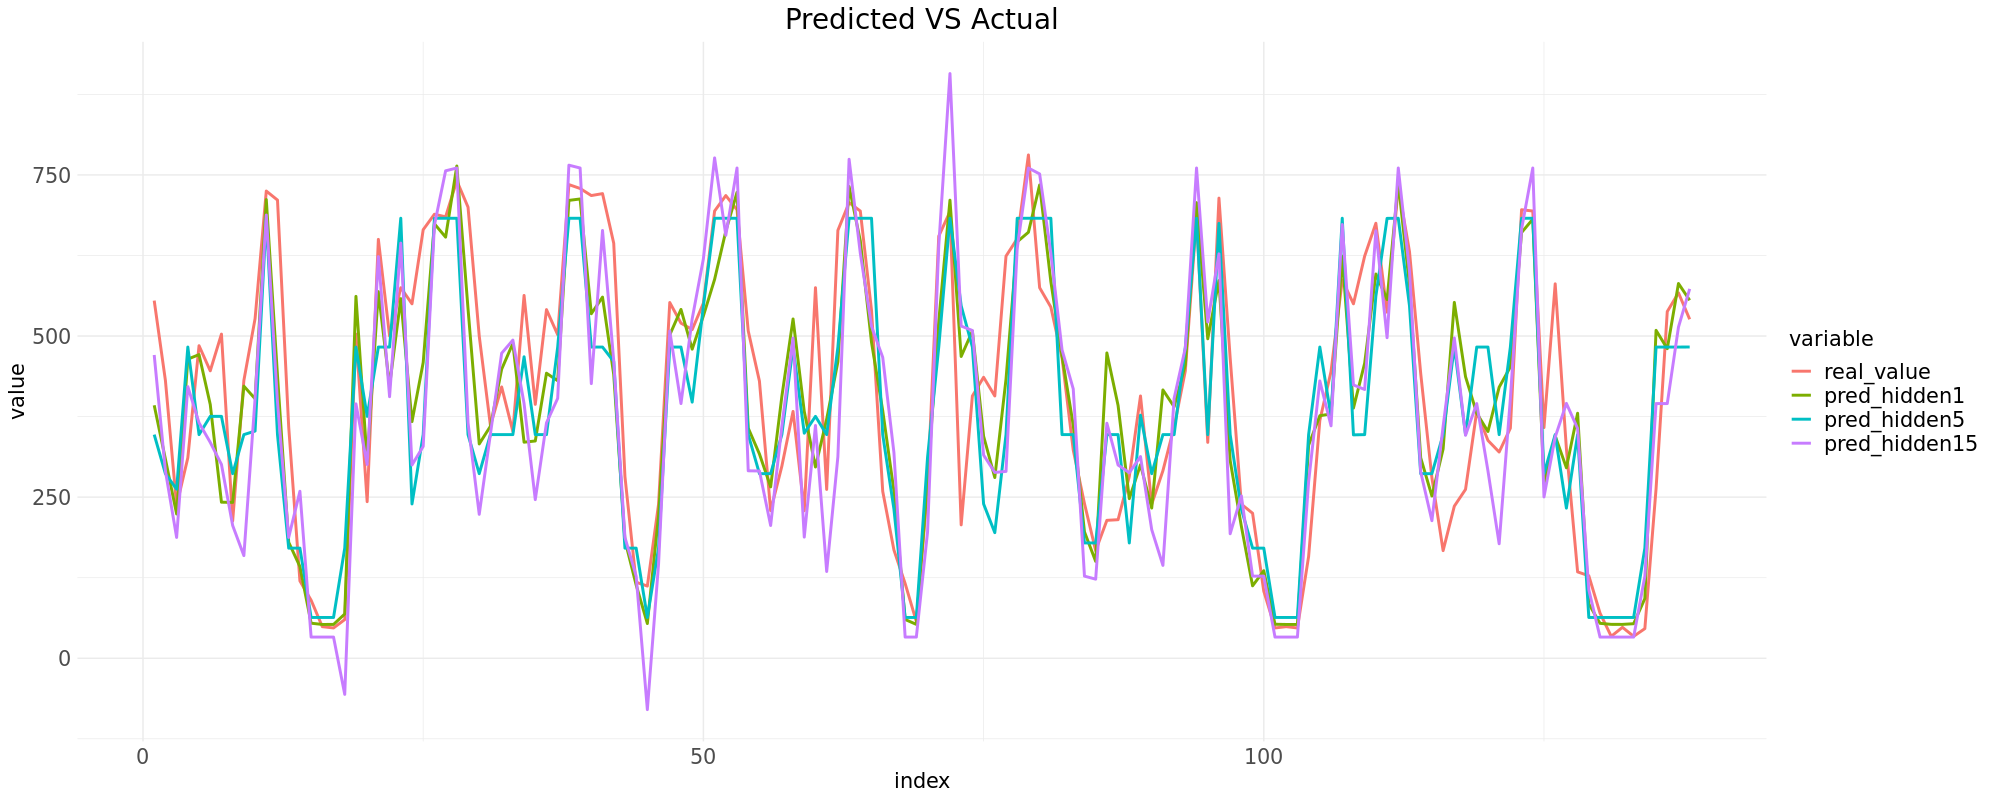

In [33]:
# 예측값과 실제값 비교(그래프)
# 시각화를 위한 데이터 reshape(widt > long)
melt_df <- melt(data.frame(real_value = test_df$CUM_RUNNINGTIME, pred_hidden1 = pred_hidden1_test_result,
                           pred_hidden5 = pred_hidden5_test_result, pred_hidden15 = pred_hidden15_test_result))
melt_df$index <- rep(1:NROW(pred_hidden1_test_result), times = 4)

options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(melt_df, aes(x = index, y = value, group = variable)) + geom_line(aes(color = variable), linewidth  = 1) + 
    ggtitle('Predicted VS Actual') + theme_minimal() + 
    theme(plot.title = element_text(hjust = 0.5, size = 20), strip.text.x = element_text(size = 15), axis.title = element_text(size = 15), axis.text = element_text(size = 15), 
          legend.text = element_text(size = 15), legend.title = element_text(size = 15))

실제값과 예측값을 비교한 그래프입니다. 붉은 선이 실제값, 초록 선이 은닉 노드 1개, 파란 선이 은닉 노드 5개, 보라색 선이 은닉 노드 15개인 모형의 예측값입니다.  

# 학습포인트

* 도메인 지식을 바탕으로 RO막 설비 1회 가동을 기준으로 연속운전시간 및 일 평균값을 산출하여 분석용 데이터셋 생성
* XGBoost(eXtreme Gradient Boosting)를 활용한 주요 독립변수 선정
* NN(Neural Network) 알고리즘을 활용한 RO막 연속운전시간 예측

# 레시피 정보

* 디지털 물산업 분야 학습용 예제 레시피 제작
* 생성일자: 2023년 5월 31일
* 사용언어: R
* Kwater 빅데이터콘테스트 발표연도 및 부서: 2021년 / 아산권지사